In [1]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

In [3]:
from PIL import ImageFile, Image
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import random
import time

In [4]:
import torch

if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. No GPUs detected.")

Number of GPUs available: 4
GPU 0: Tesla V100-SXM2-16GB
GPU 1: Tesla V100-SXM2-16GB
GPU 2: Tesla V100-SXM2-16GB
GPU 3: Tesla V100-SXM2-16GB


In [5]:
import torch
torch.cuda.empty_cache()

List of 9 image names to be removed; 6 of these have a negative PCI. Additionally, the JPEG files associated with '1119_' and '11980_' also had issues.


image_names_to_remove = [
    "1119_[40.703396736153195, -89.40525218403829]_ 2023-10-18 15-49-01_14.30605_LD.jpg",
    "6522_(40.7031446666667, -89.4013051666667)_ 2023-10-18 16-53-57_14.2894_D.jpg",
    "6706_(40.7035503333333, -89.4043398333333)_ 2023-10-18 16-59-31_0.09805_D.jpg",
    "1119_(40.7034233333333, -89.4052588333333)_ 2023-10-18 15-49-01_14.30605_D.jpg",
    "6523_(40.7031381666667, -89.4013561666667)_ 2023-10-18 16-53-58_14.73525_D.jpg",
    "1287_[40.699373956663266, -89.40239271668378]_ 2023-10-20 21-38-40_18.9699_LD.jpg",
    "11980_(40.6916493333333, -89.4393206666667)_ 2023-10-20 16-10-54_28.5085_D.jpg",
    "8536_(40.703158, -89.4063703333333)_ 2023-10-18 18-05-12_21.645_D.jpg",
    "6760_(40.7028968333333, -89.4042638333333)_ 2023-10-18 17-01-43_7.74595_D.jpg"
]

# An important note:

I have removed those 9 rows from the train.csv file that was provided in training dataset and also performed sorting to better organize the data for my analysis. Since we apply shuffling during training and aim for reproducible results, and the two CSV files are not the same, I provide the link to the CSV file that I am using. Please download it and use this file instead of the train.csv in the dataset. In my code, I have named this filtered file as filtered_train to emphasize the difference from the initial train.csv file, with 7695 rows and sorted, in contrast to the original train.csv with 7704 rows and not sorted.

https://drive.google.com/file/d/1pZPIqic56nF6CVytcucb6NvYdn63144n/view?usp=sharing

In [6]:
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(14) 

In [7]:
data = pd.read_csv('train.csv')

bins = list(range(0,105 , 5))
data['group'] = pd.cut(data.pci, bins, right=True)
group_frequency = data['group'].value_counts().sort_index()

print(group_frequency, '\n')

group
(0, 5]        314
(5, 10]        91
(10, 15]       89
(15, 20]      219
(20, 25]      240
(25, 30]      181
(30, 35]      168
(35, 40]      455
(40, 45]      625
(45, 50]      568
(50, 55]       78
(55, 60]       89
(60, 65]      964
(65, 70]       94
(70, 75]      175
(75, 80]      289
(80, 85]      116
(85, 90]      282
(90, 95]      279
(95, 100]    2367
Name: count, dtype: int64 



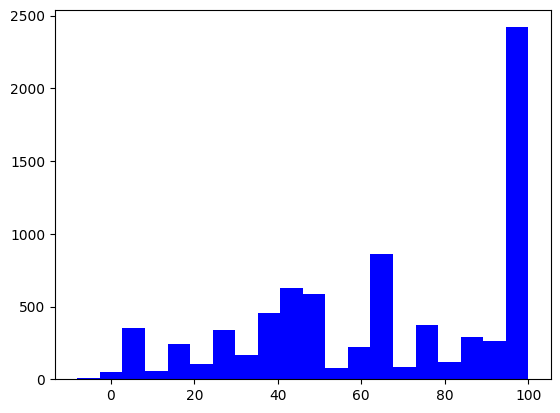

In [8]:
plt.hist(data['pci'], color='blue',  bins=20)
plt.show()

In [9]:
# Before applying oversampling for PCI values less than or equal to 30 (in the AsphaltDataset class), the general_transform was simpler.

general_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

aggressive_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
class AsphaltDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
        # Identifying indices with PCI < 30 and not equal to 4, 16, or 25
        excluded_pcis = []
        self.low_pci_indices = self.data_frame[(self.data_frame['pci'] < 35) & (~self.data_frame['pci'].isin(excluded_pcis))].index.tolist()
        
        self.indices = list(range(len(self.data_frame))) + self.low_pci_indices * 2

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Adjust to use self.indices for fetching data
        actual_idx = self.indices[idx]
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[actual_idx, 0])
        image = Image.open(img_name).convert('RGB')
        pci_value = float(self.data_frame.iloc[actual_idx, 1])

        # Apply the appropriate transformation based on PCI value
        if pci_value < 30:
            image = aggressive_transform(image)
        else:
            image = general_transform(image)

        # Transform PCI value if necessary
        pci_value = torch.tensor(pci_value, dtype=torch.float32)
        return image, pci_value
    
    
'''
Another experiment involves transforming the PCI value to be between -1 and 1:

  def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[actual_idx, 0])
        image = Image.open(img_name).convert('RGB')
        pci_value = float(self.data_frame.iloc[actual_idx, 1])
        
        # Apply the appropriate transformation based on PCI value
        if pci_value < 30:
            image = aggressive_transform(image)
        else:
            image = general_transform(image)
        
        # Transform PCI value to be between -1 and 1
        transformed_pci = (pci_value / 50) - 1
        pci_value = torch.tensor(transformed_pci, dtype=torch.float32)
        
        return image, pci_value


Another experiment involves adding a slight amount of noise to PCI values, particularly for those values associated with a large number of images (such as a PCI of 64 or 100):

def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        pci_value = self.data_frame.iloc[idx, 1]  # Assuming PCI value is in the second column
        pci_value = float(pci_value)
        
        # Add Gaussian noise to the PCI value
        noise = np.random.normal(0.5, 0.2)
        pci_value += noise

        pci_value = torch.tensor(pci_value, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, pci_value
        
*** The two experiments did not yield meaningful improvements, so I proceeded with the augmentation and oversampling already implemented in the AsphaltDataset class.        
'''

"\nAnother experiment involves transforming the PCI value to be between -1 and 1:\n\n  def __getitem__(self, idx):\n        actual_idx = self.indices[idx]\n        img_name = os.path.join(self.root_dir, self.data_frame.iloc[actual_idx, 0])\n        image = Image.open(img_name).convert('RGB')\n        pci_value = float(self.data_frame.iloc[actual_idx, 1])\n        \n        # Apply the appropriate transformation based on PCI value\n        if pci_value < 30:\n            image = aggressive_transform(image)\n        else:\n            image = general_transform(image)\n        \n        # Transform PCI value to be between -1 and 1\n        transformed_pci = (pci_value / 50) - 1\n        pci_value = torch.tensor(transformed_pci, dtype=torch.float32)\n        \n        return image, pci_value\n\n\nAnother experiment involves adding a slight amount of noise to PCI values, particularly for those values associated with a large number of images (such as a PCI of 64 or 100):\n\ndef __getitem__(s

In [11]:
# Custom Dataset Class for Inference on Testing Data
class AsphaltInferenceDataset(Dataset):
    def __init__(self, root_dir, transform=test_transform):  # Set default to general_transform
        self.root_dir = root_dir
        self.transform = transform
        self.img_names = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.lower().endswith(('png', 'jpg', 'jpeg'))]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image


In [12]:
# To ensure reproducibility, the new CSV file (filtered_train), from which 9 rows have been deleted and sorting has been applied, should be used instead of the initial train.csv.

train_dataset = AsphaltDataset(csv_file='filtered_train.csv', root_dir='Training_images')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)

test_dataset = AsphaltInferenceDataset(root_dir='Testing_images', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

In [13]:
num_train_images = len(train_dataset)
num_test_images = len(test_dataset)

print("Number of images in the training set after oversampling:", num_train_images)
print("Number of images in the testing set:", num_test_images)

Number of images in the training set after oversampling: 10251
Number of images in the testing set: 3302


In [14]:
# Model
# For the feature extraction phase, two different transformers and three CNNs were tested, and I found that swinv2_large performed the best.
# For the fully connected (fc) layer:
# (i) two models were tested: 1536-512-512-256-1 (final) and 1536-512-256-1.
# (ii) XGBoost  was tested both with and without PCI.


# Model Definition with Fine-Tuning Option
class AsphaltNet(nn.Module):
    def __init__(self, num_classes=1):
        super(AsphaltNet, self).__init__()
        self.feature_extractor = timm.create_model('swinv2_large_window12to24_192to384', pretrained=True, num_classes=0)
        self.regressor = nn.Sequential(
            nn.Linear(1536, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.regressor(features)
        return output
    
model = AsphaltNet()


if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00001)

/opt/miniconda3/envs/opence-v1.9.1/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch-base_1690385890458/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Using 4 GPUs!


In [15]:
def seconds_to_hms(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return f"{int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}"

def train_model(model, train_loader, criterion, optimizer, num_epochs=50, save_path='swinv2large'):
    model.train()
    models_dir = 'rep4'
    os.makedirs(models_dir, exist_ok=True)  # Creates the directory if it doesn't exist
    start_time = time.time()  # Start timing

    for epoch in range(num_epochs):
        running_loss = 0.0
        all_pcis = []
        all_outputs = []
        
        for images, pcis in train_loader:
            images, pcis = images.to(device), pcis.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), pcis)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Collect all outputs and pcis for metrics calculation
            all_pcis.extend(pcis.detach().cpu().numpy())
            all_outputs.extend(outputs.detach().squeeze().cpu().numpy())

        epoch_loss = running_loss / len(train_loader)
        epoch_time = time.time() - start_time  # Calculate cumulative runtime

        # Convert lists to numpy arrays for calculation
        all_pcis = np.array(all_pcis)
        all_outputs = np.array(all_outputs)

        # Calculate R^2 manually
        ss_res = np.sum((all_pcis - all_outputs) ** 2)
        ss_tot = np.sum((all_pcis - np.mean(all_pcis)) ** 2)
        r2 = 1 - ss_res / ss_tot

        # Convert epoch_time to hh:mm:ss
        formatted_time = seconds_to_hms(epoch_time)

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, R^2: {r2:.4f}, Time: {formatted_time}")

        # Save model at each epoch
        model_path = os.path.join(models_dir, f"{save_path}_epoch{epoch+1}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"Model saved at epoch {epoch+1} with Training Loss: {epoch_loss:.4f}")

    print('Training complete')

In [16]:
# Function to Perform Inference on Testing Data
def perform_inference(model, data_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images in data_loader:
            images = images.to(device)
            outputs = model(images)
            predictions.extend(outputs.cpu().numpy())
    return predictions

In [17]:
# Training the Model
train_model(model, train_loader, criterion, optimizer, num_epochs=50, save_path='swinv2large')

Epoch [1/50], Training Loss: 1195.2982, R^2: -0.0152, Time: 00:10:38
Model saved at epoch 1 with Training Loss: 1195.2982
Epoch [2/50], Training Loss: 340.7748, R^2: 0.7106, Time: 00:21:11
Model saved at epoch 2 with Training Loss: 340.7748
Epoch [3/50], Training Loss: 261.8695, R^2: 0.7777, Time: 00:31:45
Model saved at epoch 3 with Training Loss: 261.8695
Epoch [4/50], Training Loss: 214.4035, R^2: 0.8185, Time: 00:42:15
Model saved at epoch 4 with Training Loss: 214.4035
Epoch [5/50], Training Loss: 184.7744, R^2: 0.8431, Time: 00:52:45
Model saved at epoch 5 with Training Loss: 184.7744
Epoch [6/50], Training Loss: 159.7408, R^2: 0.8644, Time: 01:03:16
Model saved at epoch 6 with Training Loss: 159.7408
Epoch [7/50], Training Loss: 145.7425, R^2: 0.8763, Time: 01:13:51
Model saved at epoch 7 with Training Loss: 145.7425
Epoch [8/50], Training Loss: 128.7808, R^2: 0.8907, Time: 01:24:25
Model saved at epoch 8 with Training Loss: 128.7808
Epoch [9/50], Training Loss: 119.9189, R^2: 0

| Epoch | MAPE  | MAE  | MAPE + MAE |
|-------|-------|------|------------|
| 42    | 33.784| 8.509| 42.293     |
| 40    | 34.58 | 8.92 | 43.5       |
| 38    | 34.37 | 9.21 | 43.58      |
| 41    | 35.919| 8.053| 43.972     |

Download the best model cooresponding to Epoch 42:
https://drive.google.com/file/d/165058DYOueVK4NMP3wAbuYo8zIxCG32C/view?usp=sharing




It should also be noted that before setting a fixed seed value at the beginning of this code, I conducted another experiment in which, at Epoch 45, I obtained the following results:

| Epoch | MAPE  | MAE  | MAPE + MAE |
|-------|-------|------|------------|
| 45    | 33.226| 8.322| 41.548     |

Model:
https://drive.google.com/file/d/1p55b3a6xLvb0mVyJsnrhV1tE6j_22iF1/view?usp=sharing

json: https://drive.google.com/file/d/1gmbfSmNpAQmA5jOs0Vrs_hIkEz3LVgYB/view?usp=sharing

I also decreased the learning rate to 0.000001 after 50 epochs and trained for 15 more epochs, but I didn't observe any improvement, so I removed that part

In [ ]:
#Inference
import pandas as pd
import os
import torch
from torch.utils.data import DataLoader
import json

output_dir = 'rep4'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

    
def gen_submit(df, epoch, output_dir):
    out_json = []
    for idx, results in df.iterrows():
        out_json.append({results['image_name']: results['PCI']})
    json_file_path = os.path.join(output_dir, f'swinv2large_epoch{epoch}.json')
    with open(json_file_path, 'w') as f:
        json.dump(out_json, f)

def process_csv_to_json(csv_file_path, epoch, output_dir):
    df = pd.read_csv(csv_file_path)
    gen_submit(df, epoch, output_dir)

for epoch in range(1, 51):
    model_file_name = f'replicate/swinv2large_epoch{epoch}.pth'
    output_csv_file = os.path.join(output_dir, f'swinv2large_epoch{epoch}.csv')
    
    model.load_state_dict(torch.load(model_file_name, map_location=device))
    model.to(device)

    test_dataset = AsphaltInferenceDataset(root_dir='Testing_images', transform=test_transform)
    test_dataset.img_names = sorted(test_dataset.img_names, key=lambda x: int(os.path.basename(x).split('_')[0]))
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    predictions = perform_inference(model, test_loader, device)
    flattened_predictions = [pred[0] for pred in predictions]  # Adjust based on the structure of `predictions`
    test_file_names = [os.path.basename(fname) for fname in test_dataset.img_names]

    predictions_df = pd.DataFrame({'image_name': test_file_names, 'PCI': flattened_predictions})
    predictions_df.to_csv(output_csv_file, index=False)

    process_csv_to_json(output_csv_file, epoch, output_dir)